In [1]:
#ResNetを使って画像分類
#パッケージのインポート
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation,Add,BatchNormalization,Conv2D,Dense,Dropout,GlobalAveragePooling2D,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#データセットの準備
(train_images,train_labels),(test_images,test_labels)=cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
#データセットの前処理
train_images=train_images
train_labels=to_categorical(train_labels)
test_images=test_images
test_labels=to_categorical(test_labels)

#データセットの前処理後のシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
#モデルの作成
input=Input(shape=(784,))
x=Dense(256,activation='sigmoid')(input)
x=Dense(128,activation='sigmoid')(x)
x=Dropout(rate=0.5)(x)
x=Dense(10,activation='softmax')(x)
model=Model(inputs=input,outputs=x)

In [5]:
#畳み込み層の生成  画像は角度変えたら別と考える　画像が下とかにずれたらのも学習させる　水増しという
#圧縮させた画像を教えることを水増しという　画像処理には大事な過程
def conv(filters,kernel_size,strides=1):
  return (Conv2D(filters,kernel_size,strides=strides,padding='same',use_bias=False,
                 kernel_initializer='he_normal',kernel_regularizer=l2(0.0001)))

In [6]:
#残差ブロックAの生成
def first_residual_unit(filters,strides):
  def f(x):
    #BN,ReLU
    x=BatchNormalization()(x)
    b=Activation('relu')(x)

    #畳み込み層　BN　ReLU
    x=conv(filters // 4,1,strides)(b)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    #畳み込み層 BN ReLU  学習速度を高める手法BN
    x=conv(filters//4,3)(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    #畳み込み層
    x=conv(filters,1)(x)

    #ショートカットのシェイプサイズを確認
    sc=conv(filters,1,strides)(b)

    #Add
    return Add()([x,sc])
  return f

In [7]:
#残差ブロックBの生成 gpu ,tpu　グラフィックボード　
def residual_unit(filters):
  def f(x):
    sc=x

    #BN ReLU
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    #畳み込み層 BN ReLU
    x=conv(filters//4,1)(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    #畳み込み層 BN ReLU
    x=conv(filters // 4,3)(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    #畳み込み層
    x=conv(filters,1)(x)

    #Add
    return Add()([x,sc])
  return f

In [8]:
#残差ブロックAと残差ブロックB*17の生成
def residual_block(filters,strides,unit_size):
  def f(x):
    x=first_residual_unit(filters,strides)(x)
    for i in range(unit_size-1):
      x=residual_unit(filters)(x)
    return x
  return f

In [9]:
#入力データのシェイプ 分類
input=Input(shape=(32,32,3))

#畳み込み層
x=conv(16,3)(input)

#残差ブロック　x 54
x=residual_block(64,1,18)(x)
x=residual_block(128,2,18)(x)
x=residual_block(256,2,18)(x)

#BN ReLU
x=BatchNormalization()(x)
x=Activation('relu')(x)

#プーリング層
x=GlobalAveragePooling2D()(x)

#全結合層
output=Dense(10,activation='softmax',kernel_regularizer=l2(0.0001))(x)

#モデルの作成
model=Model(inputs=input,outputs=output)


In [10]:
#コンパイル
model.compile(loss='categorical_crossentropy',optimizer=SGD(momentum=0.9),metrics=['acc'])

In [11]:
#正規化と水増し ImageDataGenerator
#ImageDataGeneratorの準備
train_gen=ImageDataGenerator(
    featurewise_center=True, #データセット全体で入力の平均を０
    featurewise_std_normalization=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True)
test_gen=ImageDataGenerator( 
    featurewise_center=True,
    featurewise_std_normalization=True)

#データセット全体の統計量をあらかじめ計算
for data in (train_gen,test_gen):
  data.fit(train_images)

In [12]:
#学習中に学習率を変化させるコールバック
def step_decay(epoch):
  x=0.1
  if epoch>=80:x=0.01
  if epoch>=120: x=0.001
  return x
lr_decay=LearningRateScheduler(step_decay) #xがはいる

In [13]:
#学習  層が深すぎるからepochに時間かかる tpuはgpuより優秀 共通的に変数使えない cpuとは異なる tenso2.3最新 
batch_size=128
history=model.fit_generator(
    train_gen.flow(train_images,train_labels,batch_size=batch_size),
    epochs=40,
    steps_per_epoch=train_images.shape[0] //batch_size,
    validation_data=test_gen.flow(test_images,test_labels,batch_size=batch_size),
    validation_steps=test_images.shape[0] //batch_size,
    callbacks=[lr_decay])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
390/390 [==============================] - 69s 176ms/step - loss: 4.4643 - acc: 0.3592 - val_loss: 4.6053 - val_acc: 0.3449
Epoch 2/40
390/390 [==============================] - 66s 169ms/step - loss: 3.6808 - acc: 0.5335 - val_loss: 3.6236 - val_acc: 0.5346
Epoch 3/40
390/390 [==============================] - 66s 169ms/step - loss: 3.0944 - acc: 0.6398 - val_loss: 3.0705 - val_acc: 0.6059
Epoch 4/40
390/390 [==============================] - 66s 169ms/step - loss: 2.6556 - acc: 0.7082 - val_loss: 2.9046 - val_acc: 0.6188
Epoch 5/40
390/390 [==============================] - 66s 169ms/step - loss: 2.3102 - acc: 0.7513 - val_loss: 2.3893 - val_acc: 0.6994
Epoch 6/40
390/390 [==============================] - 66s 168ms/step - loss: 2.0426 - acc: 0.7787 - val_loss: 2.3938 - val_acc: 0.6756
Epoch 7/40
390/390 [==============================] - 66s 169ms/step - loss: 1.8291 - acc: 0.7953 - val_loss: 2.05

In [14]:
#モデルの保存
model.save('resnet.h5')

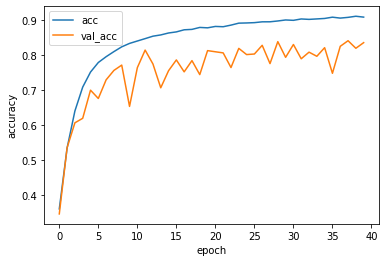

In [15]:
#グラフの表示
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [16]:
#評価  学習に使ってないデータを使ってあっているか確認
batch_size=128
test_loss,test_acc=model.evaluate_generator(
    test_gen.flow(test_images,test_labels,batch_size=batch_size),steps=10)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss,test_acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
loss: 0.875
acc: 0.826


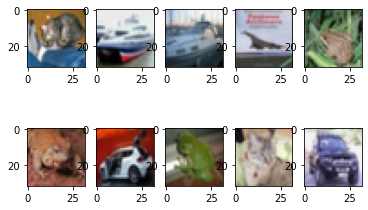

Instructions for updating:
Please use Model.predict, which supports generators.
<generator object <genexpr> at 0x7f9d1fec6e08>


In [17]:
#推論する画像の表示
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(test_images[i])
plt.show()

#推論したラベルの表示
test_predictions=model.predict_generator(
    test_gen.flow(test_images[0:10],shuffle=False,batch_size=1),steps=10)
test_predictions=np.argmax(test_predictions,axis=1)
labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print(labels[n] for n in test_predictions)